# VAE

In [1]:
USE_SERVER = True
if USE_SERVER:
    !pip install elasticsearch
    !pip install elasticsearch_dsl
    !pip install pymed
    !pip install gensim
    !pip install torchsummary

  Using cached elasticsearch-7.8.0-py2.py3-none-any.whl (188 kB)
  Using cached elasticsearch_dsl-7.2.1-py2.py3-none-any.whl (53 kB)
  Using cached pymed-0.8.9-py3-none-any.whl (9.6 kB)
     |████████████████████████████████| 24.2 MB 29.9 MB/s eta 0:00:01
  Using cached smart_open-2.1.0.tar.gz (116 kB)
  Created wheel for smart-open: filename=smart_open-2.1.0-py3-none-any.whl size=110317 sha256=de83e5c41cbe349a05fa85db4cd05793b9eb1c02dc87a18c399f3b5b0096e369
  Stored in directory: /home/ubuntu/.cache/pip/wheels/a4/9b/d5/85705a7ab783cd6f7bd718f01d3b1396272f30044e3c36401a
Successfully built smart-open
  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


In [97]:
from __future__ import print_function
import argparse
import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import utils
import os
from utils import PROJECT_ROOT, DATA_PATH
import yuval_module.paper_source as PaperSource

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

import py_4.get_mesh_vec as get_mesh_vec
import py_3.sim_matrix_3 as sim_matrix_3
import py_4.get_all_features as get_all_features 

from torch.utils.data import Dataset, DataLoader

from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
mesh_embed=get_mesh_vec.MeshEmbeddings(PROJECT_ROOT + "data/mesh_data/MeSHFeatureGeneratedByDeepWalk.csv")

In [10]:
FILE = "enriched_labeled_dataset_large" 
if os.path.exists(PROJECT_ROOT + DATA_PATH + FILE):
    print("READING FROM LOCAL")
    if FILE.split(".")[1] == "json":
        df = pd.read_json(PROJECT_ROOT + DATA_PATH + FILE)
    else:
        df = pd.read_csv(PROJECT_ROOT + DATA_PATH + FILE)
    #ps = PaperSource()
else:
    print("PULLING FROM S3")
    ps = sim_matrix_3.load_dataset(FILE)
    df = ps.get_dataset()

df.drop(columns=["last_author_country"],inplace=True)
df.rename(columns={'ORG_STATE':'last_author_country'},inplace=True)

print("FILE PULLED")

PULLING FROM S3
FILE PULLED


### Run VAE 

In [11]:
cd ..

/home/ubuntu/AYP


In [12]:
auth_core = pd.read_csv("data/train_set_author_names.csv")["0"]
auth_eps = pd.read_csv("data/val_set_author_names.csv")["0"]
auth_usecase = pd.read_csv("data/test_set_author_names.csv")["0"]

In [276]:
selection_train = list(set(df['last_author_name']) - set(auth_usecase))[:2000]
selection_test = list(set(df['last_author_name']) - set(auth_usecase))[2000:2500]

In [277]:
#settings

BATCH_SIZE= 8
EPOCHS = 30
cuda = torch.cuda.is_available()
seed = 42
log_interval = 5
num_workers = 2

#check for cuda
device = torch.device('cuda' if cuda else 'cpu')

torch.manual_seed(seed)
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

device

device(type='cuda')

In [278]:
class ToyDS(Dataset):
    def __init__(self,df,selection,vae_features = None):
        super().__init__()
        self.df = df[df['last_author_name'].isin(selection)]
        if vae_features is None:
            print("Creating new VAE FEATURES")
            self.vae_features = get_all_features.VAE_Features(self.df)
        else:
            print("Using pre-defined VAE FEATURES")
            self.vae_features = vae_features
        self.features = self.vae_features.get_all_features(self.df)
        print(list(self.vae_features.mesh_features.mesh_missing))
        self.input_dim = self.vae_features.input_dims
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        features = self.features[idx]
        return features
    
    def __getvae__(self):
        return self.vae_features

In [279]:
train_set = ToyDS(df, selection_train)
train_loader=DataLoader(dataset= train_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)

Creating new VAE FEATURES
'/home/ubuntu/AYP/code/models/names_epochs_2_vectorSize_64_window_2.model' already exits. Using existing model to re-generate results.
'/home/ubuntu/AYP/code/models/co_authors_epochs_2_vectorSize_64_window_2.model' already exits. Using existing model to re-generate results.


/home/ubuntu/AYP/code/py_4/get_all_features.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['co_authors']=df.authors.apply( lambda x: [i['name'] for i in x] )


Defining new scaler
['MESH NAME NOT FOUND: Mitophagy', 'MESH NAME NOT FOUND: Female', "MESH NAME NOT FOUND: Practice Patterns, Physicians'", 'MESH NAME NOT FOUND: Broadly Neutralizing Antibodies', 'MESH NAME NOT FOUND: B-Cell Lymphoma 3 Protein', 'MESH NAME NOT FOUND: Conditioning, Psychological', 'MESH NAME NOT FOUND: Inhibition, Psychological', 'MESH NAME NOT FOUND: Chlorocebus aethiops', 'MESH NAME NOT FOUND: Confounding Factors, Epidemiologic', 'MESH NAME NOT FOUND: Male', 'MESH NAME NOT FOUND: Recognition, Psychology', 'MESH NAME NOT FOUND: Phosphoinositide-3 Kinase Inhibitors', 'MESH NAME NOT FOUND: Infections', 'MESH NAME NOT FOUND: Stimuli Responsive Polymers', 'MESH NAME NOT FOUND: Copper-Transporting ATPases']


In [280]:
print("The number of features: ",train_set.input_dim)
print("The number of train data: ",train_set.__len__())

The number of features:  64
The number of train data:  11051


In [281]:
class VAE(nn.Module):
    def __init__(self, input_dim = train_set.input_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.Linear(self.input_dim, 64)
        self.fc21 = nn.Linear(64, 32)
        self.fc22 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, self.input_dim)
        
        #Want to initialize logvar weights to 0
#         self.fc22.weight.data.fill_(0)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
#         return torch.sigmoid(self.fc4(h3))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z

In [282]:
def loss_function(recon_x, x, mu, logvar,epoch):
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 64), reduction='sum')

    MSE = F.mse_loss(recon_x, x.view(-1, train_set.input_dim))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= BATCH_SIZE * train_set.input_dim
    
    gamma = min(1.0,np.log(epoch+1))
    
    gamma = 0

    return MSE + gamma*KLD

In [283]:
log_interval = 10

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [284]:
from torchsummary import summary
summary(model, (20,train_set.input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           4,160
            Linear-2                   [-1, 32]           2,080
            Linear-3                   [-1, 32]           2,080
            Linear-4                   [-1, 64]           2,112
            Linear-5                   [-1, 64]           4,160
Total params: 14,592
Trainable params: 14,592
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [285]:
def train_epoch(tr_loader, model, criterion, optimizer, num_epochs):
    model.train()
    train_log = []
    
    for epoch in range(num_epochs):
        print("Started training epoch no. {}".format(epoch+1))
        train_loss= 0
        for batch_idx, data in enumerate(train_loader):
            data = data.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            recon_batch, mu, logvar, z = model(data)
            loss = criterion(recon_batch, data, mu, logvar,epoch)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}\n'.format(
            epoch, train_loss / len(train_loader.dataset)))
        train_log.append({
            'epoch': epoch,
            'train_loss': train_loss / len(train_loader)})
    return train_log

In [303]:
def test_model(test_loader, model):
    model.eval()
    recon_batchs = []
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device, dtype=torch.float32)
            recon_batch, mu, logvar, _ = model(data)
            if eval:
                recon_batchs.extend(recon_batch.cpu().detach().numpy())
            else:
                 recon_batchs.extend(recon_batch.detach().numpy())
            test_loss += loss_function(recon_batch, data, mu, logvar,0).item()
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return np.array(recon_batchs)

In [287]:
train_log = train_epoch(train_loader,model,loss_function,optimizer,num_epochs= EPOCHS)

Started training epoch no. 1
Train Epoch: 0 [0/11051 (0%)]	Loss: 0.087897
Train Epoch: 0 [80/11051 (1%)]	Loss: 0.147597
Train Epoch: 0 [160/11051 (1%)]	Loss: 0.182933
Train Epoch: 0 [240/11051 (2%)]	Loss: 0.137266
Train Epoch: 0 [320/11051 (3%)]	Loss: 0.100427
Train Epoch: 0 [400/11051 (4%)]	Loss: 0.088912
Train Epoch: 0 [480/11051 (4%)]	Loss: 0.082911
Train Epoch: 0 [560/11051 (5%)]	Loss: 0.054997
Train Epoch: 0 [640/11051 (6%)]	Loss: 0.124801
Train Epoch: 0 [720/11051 (7%)]	Loss: 0.118962
Train Epoch: 0 [800/11051 (7%)]	Loss: 0.058551
Train Epoch: 0 [880/11051 (8%)]	Loss: 0.093100
Train Epoch: 0 [960/11051 (9%)]	Loss: 0.105863
Train Epoch: 0 [1040/11051 (9%)]	Loss: 0.059365
Train Epoch: 0 [1120/11051 (10%)]	Loss: 0.119079
Train Epoch: 0 [1200/11051 (11%)]	Loss: 0.041897
Train Epoch: 0 [1280/11051 (12%)]	Loss: 0.076726
Train Epoch: 0 [1360/11051 (12%)]	Loss: 0.112718
Train Epoch: 0 [1440/11051 (13%)]	Loss: 0.131187
Train Epoch: 0 [1520/11051 (14%)]	Loss: 0.089719
Train Epoch: 0 [1600/

In [288]:
train_log

[{'epoch': 0, 'train_loss': 0.5167462586677282},
 {'epoch': 1, 'train_loss': 0.28524630707210163},
 {'epoch': 2, 'train_loss': 0.22405595366617964},
 {'epoch': 3, 'train_loss': 0.20420735602451734},
 {'epoch': 4, 'train_loss': 0.19710183489188962},
 {'epoch': 5, 'train_loss': 0.1930222342170872},
 {'epoch': 6, 'train_loss': 0.19041850625951107},
 {'epoch': 7, 'train_loss': 0.18789771827296306},
 {'epoch': 8, 'train_loss': 0.1866707818032756},
 {'epoch': 9, 'train_loss': 0.18474156394811123},
 {'epoch': 10, 'train_loss': 0.18310086487478397},
 {'epoch': 11, 'train_loss': 0.18228452956417168},
 {'epoch': 12, 'train_loss': 0.1804202217783903},
 {'epoch': 13, 'train_loss': 0.17962252591533098},
 {'epoch': 14, 'train_loss': 0.17927590616494848},
 {'epoch': 15, 'train_loss': 0.17819420022919624},
 {'epoch': 16, 'train_loss': 0.17817324729213105},
 {'epoch': 17, 'train_loss': 0.17705244246557592},
 {'epoch': 18, 'train_loss': 0.17651008013177624},
 {'epoch': 19, 'train_loss': 0.17582387165550

In [297]:
test_set = ToyDS(df, selection_test, vae_features = train_set.__getvae__())
test_loader=DataLoader(dataset= test_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)

Using pre-defined VAE FEATURES


/home/ubuntu/AYP/code/py_4/get_all_features.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['co_authors']=df.authors.apply( lambda x: [i['name'] for i in x] )


Using old scaler
['MESH NAME NOT FOUND: Mitophagy', 'MESH NAME NOT FOUND: Female', "MESH NAME NOT FOUND: Practice Patterns, Physicians'", 'MESH NAME NOT FOUND: Broadly Neutralizing Antibodies', 'MESH NAME NOT FOUND: B-Cell Lymphoma 3 Protein', 'MESH NAME NOT FOUND: Conditioning, Psychological', 'MESH NAME NOT FOUND: Inhibition, Psychological', 'MESH NAME NOT FOUND: Discrimination, Psychological', 'MESH NAME NOT FOUND: Chlorocebus aethiops', 'MESH NAME NOT FOUND: Confounding Factors, Epidemiologic', 'MESH NAME NOT FOUND: Male', 'MESH NAME NOT FOUND: Recognition, Psychology', 'MESH NAME NOT FOUND: Phosphoinositide-3 Kinase Inhibitors', 'MESH NAME NOT FOUND: Infections', 'MESH NAME NOT FOUND: Stimuli Responsive Polymers', 'MESH NAME NOT FOUND: Copper-Transporting ATPases']


In [298]:
test_set.features.shape

(2570, 64)

In [304]:
x_hat_test = test_model(test_loader, model)

====> Test set loss: 0.0255


In [305]:
x_hat_test.shape

(2570, 64)

# Test

In [153]:
selection = [auth_usecase[109]]
print(df[df['last_author_name'].isin(selection)]["PI_IDS"].value_counts())

7127687     10
10594466     8
11990780     1
Name: PI_IDS, dtype: int64


In [154]:
train_vae = train_set.__getvae__()
test_set = ToyDS(df, selection,train_vae)
test_loader=DataLoader(dataset= test_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)

Using pre-defined VAE FEATURES
Using old scaler
['MESH NAME NOT FOUND: Female', "MESH NAME NOT FOUND: Practice Patterns, Physicians'", 'MESH NAME NOT FOUND: Phosphoinositide-3 Kinase Inhibitors', 'MESH NAME NOT FOUND: Chlorocebus aethiops', 'MESH NAME NOT FOUND: Male', 'MESH NAME NOT FOUND: Phospholipid Hydroperoxide Glutathione Peroxidase', 'MESH NAME NOT FOUND: Outcome Assessment, Health Care', 'MESH NAME NOT FOUND: Diet, Healthy', 'MESH NAME NOT FOUND: Copper-Transporting ATPases']


/home/ubuntu/AYP/code/py_4/get_all_features.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['co_authors']=df.authors.apply( lambda x: [i['name'] for i in x] )


In [155]:
bottle_neck=[]
recon_batchs = []
for batch_idx, data in enumerate(test_loader):
            data = data.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            recon_batch, mu, logvar, _= model(data)
            if cuda:
                bottle_neck.extend(mu.cpu().detach().numpy())
                recon_batchs.extend(recon_batch.cpu().detach().numpy())
            else:
                bottle_neck.extend(mu.detach().numpy())
                recon_batchs.extend(recon_batch.detach().numpy())
bottle_neck = np.array(bottle_neck)
recon_batchs = np.array(recon_batchs)
print(bottle_neck.shape)
print(recon_batchs.shape)

(19, 32)
(19, 64)


In [157]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=1, n_iter=1000,random_state=42)
tsne_results = tsne.fit_transform(bottle_neck)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 0.634541
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.133377
[t-SNE] KL divergence after 1000 iterations: 0.337330
t-SNE done! Time elapsed: 0.14081168174743652 seconds


In [158]:
df_subset=pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['PI'] = list(df[df['last_author_name'].isin(selection)]["PI_IDS"])

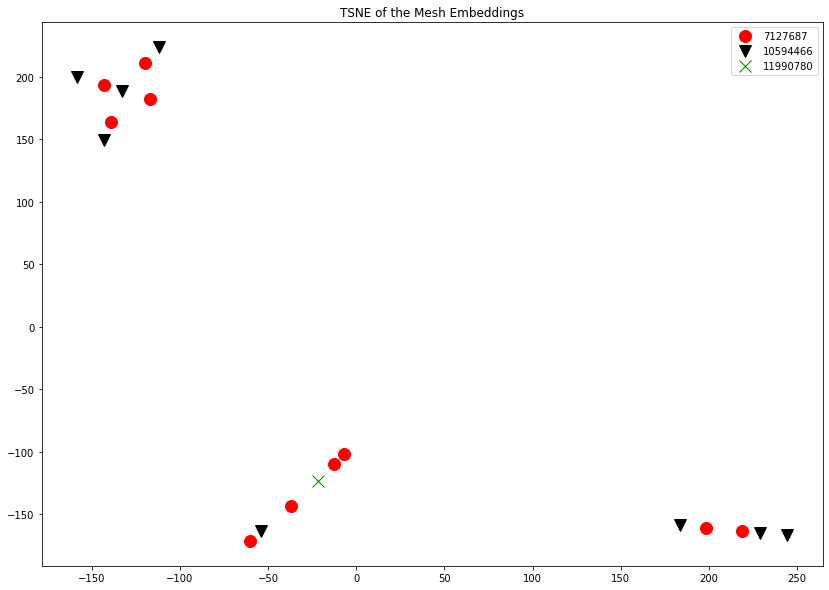

In [159]:
groups = df_subset.groupby('PI')
markers = ['o','v',"x"]
colors = ["red","black","green"]
# Plot
fig, ax = plt.subplots(figsize=(14,10))

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for i, (name, group) in enumerate(groups):
    ax.set_title("TSNE of the Mesh Embeddings")
    ax.plot(group['tsne-2d-one'], group['tsne-2d-two'], marker=markers[i], linestyle='', ms=12, label=name, color=colors[i])
ax.legend()
plt.show()
fig.tight_layout();

# fig.savefig('code/img/TSNE_Plots/mesh.png', bbox_inches='tight')

### SANITY TESTS

#### ON INPUT DIM:

In [160]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=2, n_iter=1000, random_state=42)
tsne_inputs = tsne.fit_transform(test_set.features)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
input_testset=pd.DataFrame()
input_testset['tsne-2d-one'] = tsne_inputs[:,0]
input_testset['tsne-2d-two'] = tsne_inputs[:,1]
input_testset['PI'] = list(df[df['last_author_name'].isin(selection)]["PI_IDS"])

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.712021
[t-SNE] KL divergence after 1000 iterations: 0.240680
t-SNE done! Time elapsed: 0.14115023612976074 seconds


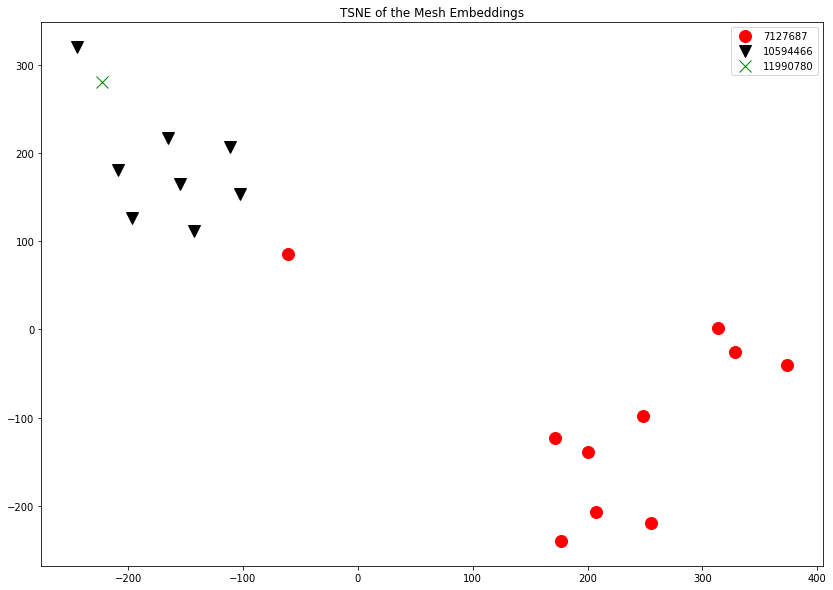

In [161]:
groups = input_testset.groupby('PI')
markers = ['o','v',"x"]
colors = ["red","black","green"]
# Plot
fig, ax = plt.subplots(figsize=(14,10))

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for i, (name, group) in enumerate(groups):
    ax.set_title("TSNE of the Mesh Embeddings")
    ax.plot(group['tsne-2d-one'], group['tsne-2d-two'], marker=markers[i], linestyle='', ms=12, label=name, color=colors[i])
ax.legend()
plt.show()
fig.tight_layout();

# fig.savefig('code/img/TSNE_Plots/mesh.png', bbox_inches='tight')

### OUTPUT DIMS

In [162]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=2, n_iter=1000,random_state=42)
tsne_output = tsne.fit_transform(recon_batchs)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
output_testset=pd.DataFrame()
output_testset['tsne-2d-one'] = tsne_output[:,0]
output_testset['tsne-2d-two'] = tsne_output[:,1]
output_testset['PI'] = list(df[df['last_author_name'].isin(selection)]["PI_IDS"])

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 0.000622
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.051392
[t-SNE] KL divergence after 1000 iterations: 0.264274
t-SNE done! Time elapsed: 0.14203095436096191 seconds


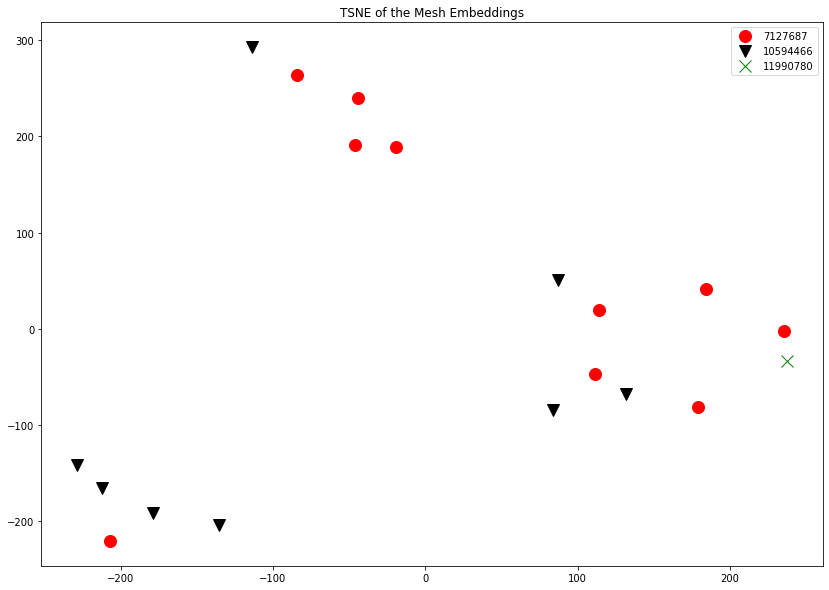

In [163]:
groups = output_testset.groupby('PI')
markers = ['o','v',"x"]
colors = ["red","black","green"]
# Plot
fig, ax = plt.subplots(figsize=(14,10))

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for i, (name, group) in enumerate(groups):
    ax.set_title("TSNE of the Mesh Embeddings")
    ax.plot(group['tsne-2d-one'], group['tsne-2d-two'], marker=markers[i], linestyle='', ms=12, label=name, color=colors[i])
ax.legend()
plt.show()
fig.tight_layout();

# fig.savefig('code/img/TSNE_Plots/mesh.png', bbox_inches='tight')

### NO MANS LAND

In [314]:
np.mean(test_set.features,axis=0)

array([ 0.04696874, -0.00745973,  0.02219138, -0.01152058,  0.07750552,
       -0.05652783,  0.0463714 ,  0.04440367,  0.01624255, -0.04389438,
        0.00964473,  0.02568895,  0.0059289 ,  0.0445687 ,  0.01514376,
       -0.00167513, -0.00547519, -0.12151582,  0.04825244,  0.01406206,
       -0.0263554 , -0.05763874,  0.03104352, -0.0210744 ,  0.06944894,
       -0.00496328, -0.00685616,  0.02910295, -0.0491034 , -0.01197104,
        0.03281267,  0.03191182, -0.00297394,  0.00091517,  0.00926172,
        0.05470938,  0.03836613, -0.05525067,  0.02519614, -0.02490205,
        0.05078975, -0.06835574,  0.002885  ,  0.01828441, -0.03423334,
        0.02593969,  0.01156024,  0.00615533, -0.02579997,  0.0045107 ,
       -0.00383745, -0.04143269,  0.02803731,  0.05674217, -0.03228447,
        0.01210703,  0.00111895,  0.00200509,  0.05567061, -0.02285567,
        0.00041651, -0.00045409,  0.00020516,  0.01223247])

In [313]:
np.mean(x_hat_test,axis=0)

array([ 0.08774614,  0.02092163,  0.12571853, -0.14216335,  0.07720881,
       -0.15472281,  0.14757884,  0.06413764,  0.02327864, -0.06940445,
        0.06744818,  0.06021205,  0.05749616,  0.07097321, -0.00946512,
        0.10901033,  0.04193162, -0.16763069,  0.05569793,  0.02644674,
       -0.12107595, -0.01172395, -0.00654568,  0.02205859, -0.03049977,
        0.00936542, -0.03355218,  0.06486404, -0.01426596, -0.03592556,
        0.02135579,  0.03412693,  0.05554745, -0.12500796,  0.05881401,
       -0.00335602,  0.09905915, -0.09426896,  0.05038181,  0.00551764,
        0.0877351 , -0.02228821,  0.06608629, -0.07717218, -0.12320602,
        0.04910495, -0.09248894,  0.08001823, -0.02947531, -0.02167947,
       -0.07819159, -0.06418394, -0.00188549,  0.03362697, -0.17517133,
        0.05104881,  0.02952922, -0.03766378,  0.07698775,  0.08726925,
       -0.09581321,  0.04931774, -0.03959464,  0.03322336], dtype=float32)

In [317]:
np.mean(np.abs(test_set.features - x_hat_test))

1.0439939456221106

array([-0.48664856,  0.5514309 ,  0.19388752, -0.42018056, -0.3232441 ,
        0.67790425,  0.6908368 , -0.07615533, -0.1124628 , -0.14229044,
        1.2183169 ,  0.86753476,  0.14473648,  0.08594865,  0.56901103,
       -0.14818126,  0.10047996, -0.4192718 ,  0.0617242 ,  0.13661231,
        0.52298164,  0.18177733, -0.2841749 ,  0.1585145 ,  0.03479505,
        0.2453199 ,  0.04435132, -0.7162493 ,  0.4566654 ,  0.23147944,
       -0.04918338, -0.00181377,  0.07591151, -0.09561956, -0.01763365,
        0.23789018, -0.36632562,  0.11252811, -0.3439671 , -0.3704161 ,
       -1.0691663 ,  0.6125722 ,  0.22568542,  0.03408474,  0.06912109,
       -0.10103416, -1.7580557 , -1.5552766 ,  0.5394255 , -0.4705413 ,
       -0.17830682,  0.39068723, -0.8519199 , -0.9528599 , -0.3563116 ,
       -0.16227925, -0.26426497, -0.67982227,  0.32561398,  0.48522398,
       -0.00678802, -0.17770773,  0.8744967 , -1.0235527 ], dtype=float32)